In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import itertools

import os, sys

project_root = '/user_data/mmhender/featsynth/'
# sys.path.append(os.path.join(project_root, 'code'))
sys.path.insert(0, os.path.join(project_root, 'code'))
from utils import stats_utils, plot_utils
from behav_analysis import analyze_expt1

In [2]:
super_names, super_cbinds, basic_names, basic_inds, \
        super_names_long, super_inds_long, n_basic, n_super, n_basic_each_super = \
            analyze_expt1.get_categ_info()

trial_data_all, subjects, subject_cb, cue_level_names, image_type_names = analyze_expt1.load_data()
 
n_subjects = len(subjects)
n_cue_levels = len(cue_level_names)
n_image_types = len(image_type_names)

acc_by_condition, dprime_by_condition, propyes_by_condition, rt_by_condition = \
    analyze_expt1.get_perf_by_cond_excludebirds()


#### Plotting params

In [3]:
cue_level_colors = np.array([[93,192,219], [44,92,168]])/255
point_types = ['o','x']
markersize = 4;
xjitters = np.array([-0.2, 0.2])
barwidth = xjitters[1]*2

#### d-prime values: two-way repeated measures anova, all subjects

In [4]:
vals = dprime_by_condition

print('\nAll subjects:')
print(vals.shape)

aov_table = stats_utils.rmanova_2way(vals, ['cond','image_type'])

print(aov_table)


All subjects:
(47, 2, 5)
                    F Value  Num DF  Den DF        Pr > F
cond             148.797260     1.0    46.0  5.092890e-16
image_type       302.896233     4.0   184.0  8.983631e-80
cond:image_type    5.102535     4.0   184.0  6.382988e-04


#### t-tests comparing basic vs superordinate, within image type

In [5]:
tvals = np.zeros((5,))
pvals = np.zeros((5,))

df = pd.DataFrame(index=image_type_names)

vals = dprime_by_condition

print('All subjects:')
print(vals.shape)

for ii in range(n_image_types):

    p, t = stats_utils.paired_ttest_nonpar(vals[:,0,ii], vals[:,1,ii])

    tvals[ii] = t
    pvals[ii] = p

df['t (basic-super)'] = tvals.round(4)

_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')
df['p'] = pvals_fdr
# df['p'] = pvals
        
df        
    

All subjects:
(47, 2, 5)


,t (basic-super),p
pool1,-3.6649,0.000
pool2,-8.2387,0.000
pool3,-6.9855,0.000
pool4,-8.4211,0.000
orig,-3.7380,0.002


#### plot dprime, all subjects

Text(0.5, 1.0, 'All subjects (n=47)')

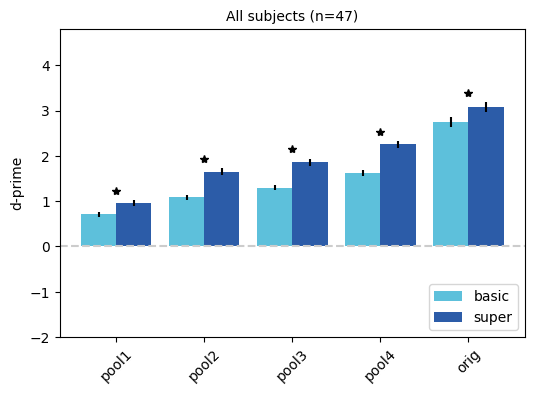

In [6]:
plot_utils.set_all_font_sizes(10)
plt.figure(figsize=(6,4))

vals = dprime_by_condition

n_subs_plot = vals.shape[0]
    
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)
  
ax = plt.subplot(1,1,1)


lh = []

for ii in range(n_image_types):
    
    for cc, cue in enumerate(cue_level_names):
    
        h = plt.bar(ii+xjitters[cc], \
                         meanvals[cc,ii], \
                        color = cue_level_colors[cc,:], width=barwidth)
        
        plt.errorbar(ii+xjitters[cc], \
                         meanvals[cc,ii], \
                         semvals[cc,ii], \
                        color = 'k',
                        linestyle='none')
    
        lh.append(h)

    if pvals[ii]<0.01:
        height = np.max(meanvals[:,ii]+semvals[:,ii])+0.20
        plt.plot(ii, height, '*', color='k')

    
plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)

    
    

plt.axhline(0.0, color=[0.8, 0.8, 0.8], linestyle='--')

ax.legend(lh, cue_level_names, loc='lower right')

plt.ylabel('d-prime')

plt.ylim([-2, 4.8])

plt.title('All subjects (n=%d)'%(n_subs_plot))

#### pairwise comparisons across image types

In [7]:
pairs_test = list(itertools.combinations(np.arange(5),2))
n_pairs = len(pairs_test)
pair_names = ['%s vs %s'%(image_type_names[ii], image_type_names[jj]) for ii, jj in pairs_test]

tvals = np.zeros((n_pairs))
pvals = np.zeros((n_pairs))

df = pd.DataFrame(index=pair_names)

# averaging across basic/super conds here
vals = np.mean(dprime_by_condition, axis=1)

for pi, pair in enumerate(pairs_test):

    vals1 = vals[:,pair[0]]
    vals2 = vals[:,pair[1]]

    p, t = stats_utils.paired_ttest_nonpar(vals1, vals2)

    tvals[pi] = t
    pvals[pi] = p

df['t'] = tvals.round(4)

_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')
df['p'] = pvals_fdr

df   

,t,p
pool1 vs pool2,-8.5907,0.0
pool1 vs pool3,-15.0396,0.0
pool1 vs pool4,-21.0784,0.0
pool1 vs orig,-25.9134,0.0
pool2 vs pool3,-3.6601,0.0
pool2 vs pool4,-10.2997,0.0
pool2 vs orig,-20.1643,0.0
pool3 vs pool4,-8.4845,0.0
pool3 vs orig,-17.6417,0.0
pool4 vs orig,-14.9995,0.0


#### d-prime: separate out the two image sets

In [8]:
for cbi, cb in enumerate([1,2]):
    
    subjects_plot = (subject_cb==cbi) 
    n_subs_plot = np.sum(subjects_plot)
    
    vals = dprime_by_condition[subjects_plot,:,:]
    
    print('\nImage set %d:'%cb)
    print(vals.shape)
    
    aov_table = stats_utils.rmanova_2way(vals, ['cond','image_type'])

    print(aov_table)


Image set 1:
(23, 2, 5)
                    F Value  Num DF  Den DF        Pr > F
cond              50.657567     1.0    22.0  3.882537e-07
image_type       202.264471     4.0    88.0  1.748063e-43
cond:image_type    4.174836     4.0    88.0  3.834995e-03

Image set 2:
(24, 2, 5)
                    F Value  Num DF  Den DF        Pr > F
cond             123.342781     1.0    23.0  1.019530e-10
image_type       170.458059     4.0    92.0  1.188119e-41
cond:image_type    7.576509     4.0    92.0  2.540961e-05


#### t-tests comparing basic vs superordinate, within image type

In [9]:
tvals = np.zeros((2,5))
pvals = np.zeros((2,5))

df = pd.DataFrame(index=image_type_names)

for cbi, cb in enumerate([1,2]):
    
    subjects_plot = (subject_cb==cbi) 
    n_subs_plot = np.sum(subjects_plot)
    
    vals = dprime_by_condition[subjects_plot,:,:]
    
    print('\nImage set %d:'%cb)
    print(vals.shape)
    
    for ii in range(n_image_types):
        
        p, t = stats_utils.paired_ttest_nonpar(vals[:,0,ii], vals[:,1,ii])
        
        tvals[cbi, ii] = t
        pvals[cbi, ii] = p
        
# fdr correcting all the values together
_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')

for cbi, cb in enumerate([1,2]):
    
    df['Set %d: t'%cb] = tvals[cbi,:].round(4)
    df['Set %d: p'%cb] = pvals_fdr[cbi,:]
    

df


Image set 1:
(23, 2, 5)

Image set 2:
(24, 2, 5)


,Set 1: t,Set 1: p,Set 2: t,Set 2: p
pool1,-1.4812,0.133333,-4.0907,0.0025
pool2,-6.3627,0.000000,-5.7580,0.0000
pool3,-4.0773,0.000000,-6.2350,0.0000
pool4,-4.7870,0.000000,-7.4858,0.0000
orig,-4.1088,0.000000,-1.1616,0.2720


#### plot d-prime for each image set

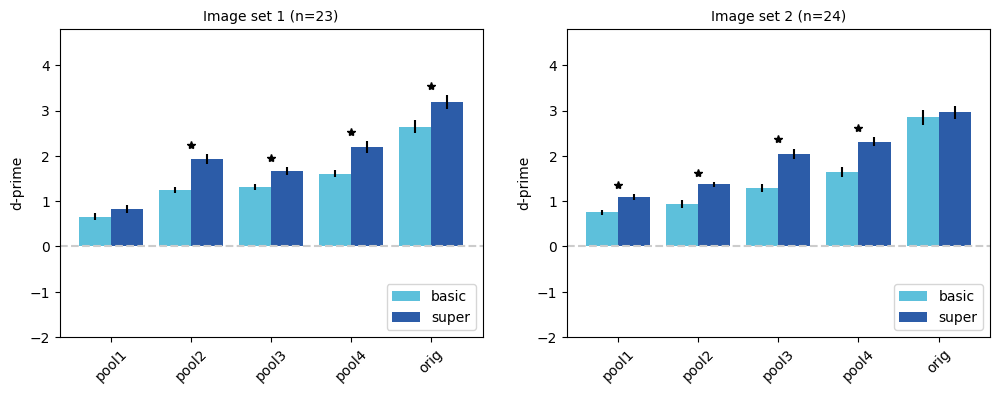

In [10]:
plot_utils.set_all_font_sizes(10)
plt.figure(figsize=(12,4))
    
for cbi, cb in enumerate([1,2]):

    ax = plt.subplot(1,2,cb)
    
    vals = dprime_by_condition[subject_cb==cbi,:,:]
    
    n_subs_plot = vals.shape[0]
        
    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)
    
    lh = []
    
    for ii in range(n_image_types):
        
        for cc, cue in enumerate(cue_level_names):
        
            h = plt.bar(ii+xjitters[cc], \
                             meanvals[cc,ii], \
                            color = cue_level_colors[cc,:], width=barwidth)
            
            plt.errorbar(ii+xjitters[cc], \
                             meanvals[cc,ii], \
                             semvals[cc,ii], \
                            color = 'k',
                            linestyle='none')
        
            lh.append(h)
    
        if pvals[cbi, ii]<0.01:
            height = np.max(meanvals[:,ii]+semvals[:,ii])+0.20
            plt.plot(ii, height, '*', color='k')
    
        
    plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)
    
        
        
    
    plt.axhline(0.0, color=[0.8, 0.8, 0.8], linestyle='--')
    
    ax.legend(lh, cue_level_names, loc='lower right')
    
    plt.ylabel('d-prime')
    
    plt.ylim([-2, 4.8])
    
    plt.title('Image set %d (n=%d)'%(cb, n_subs_plot))

#### Analyze RTs

In [11]:
vals = rt_by_condition

print('\nAll subjects:')
print(vals.shape)

aov_table = stats_utils.rmanova_2way(vals, ['cond','image_type'])

print(aov_table)


All subjects:
(47, 2, 5)
                   F Value  Num DF  Den DF        Pr > F
cond              1.617543     1.0    46.0  2.098273e-01
image_type       20.431559     4.0   184.0  6.054387e-14
cond:image_type   4.342309     4.0   184.0  2.223271e-03


#### compare basic vs superordinate, within image type

In [12]:
tvals = np.zeros((5,))
pvals = np.zeros((5,))

df = pd.DataFrame(index=image_type_names)

vals = rt_by_condition

print('All subjects:')
print(vals.shape)

for ii in range(n_image_types):

    p, t = stats_utils.paired_ttest_nonpar(vals[:,0,ii], vals[:,1,ii])

    tvals[ii] = t
    pvals[ii] = p

df['t (basic-super)'] = tvals.round(4)

_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')
df['p'] = pvals_fdr
        
df        
    

All subjects:
(47, 2, 5)


,t (basic-super),p
pool1,-2.9131,0.040000
pool2,-0.6290,0.690000
pool3,-0.3196,0.706000
pool4,1.5483,0.216667
orig,-1.6212,0.216667


#### plot RTs, all subjects

Text(0.5, 1.0, 'All subjects (n=47)')

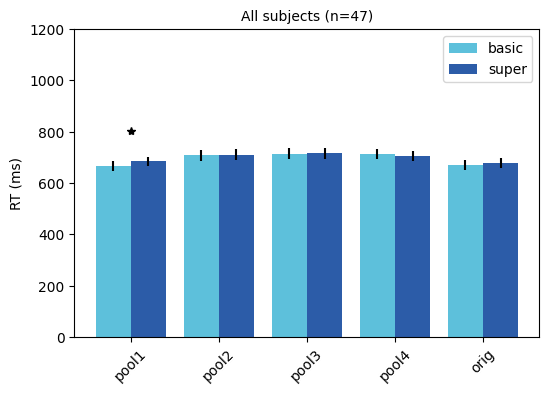

In [13]:
plot_utils.set_all_font_sizes(10)
plt.figure(figsize=(6,4))

vals = rt_by_condition

n_subs_plot = vals.shape[0]
    
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)
  
ax = plt.subplot(1,1,1)


lh = []

for ii in range(n_image_types):
    
    for cc, cue in enumerate(cue_level_names):
    
        h = plt.bar(ii+xjitters[cc], \
                         meanvals[cc,ii], \
                        color = cue_level_colors[cc,:], width=barwidth)
        
        plt.errorbar(ii+xjitters[cc], \
                         meanvals[cc,ii], \
                         semvals[cc,ii], \
                        color = 'k',
                        linestyle='none')
    
        lh.append(h)

    if pvals[ii]<0.01:
        height = np.max(meanvals[:,ii]+semvals[:,ii])+100
        plt.plot(ii, height, '*', color='k')

    
plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)

    
    

# plt.axhline(0.0, color=[0.8, 0.8, 0.8], linestyle='--')

ax.legend(lh, cue_level_names, loc='upper right')

plt.ylabel('RT (ms)')

plt.ylim([0, 1200])

plt.title('All subjects (n=%d)'%(n_subs_plot))

#### pairwise comparisons across image types

In [14]:

pairs_test = list(itertools.combinations(np.arange(5),2))
n_pairs = len(pairs_test)
pair_names = ['%s vs %s'%(image_type_names[ii], image_type_names[jj]) for ii, jj in pairs_test]

tvals = np.zeros((n_pairs))
pvals = np.zeros((n_pairs))

df = pd.DataFrame(index=pair_names)


# averaging across basic/super conds here
vals = np.mean(rt_by_condition, axis=1)

for pi, pair in enumerate(pairs_test):

    vals1 = vals[:,pair[0]]
    vals2 = vals[:,pair[1]]

    p, t = stats_utils.paired_ttest_nonpar(vals1, vals2)

    tvals[pi] = t
    pvals[pi] = p

df['t'] = tvals.round(4)

_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')
df['p'] = pvals_fdr


df   

,t,p
pool1 vs pool2,-7.0801,0.000000
pool1 vs pool3,-6.4979,0.000000
pool1 vs pool4,-4.7433,0.000000
pool1 vs orig,0.1378,0.924000
pool2 vs pool3,-2.0964,0.042857
pool2 vs pool4,-0.0988,0.924000
pool2 vs orig,4.3338,0.000000
pool3 vs pool4,1.9911,0.072500
pool3 vs orig,5.6665,0.000000
pool4 vs orig,6.0275,0.000000


#### RTs: separate out the two image sets

In [15]:
for cbi, cb in enumerate([1,2]):
    
    subjects_plot = (subject_cb==cbi) 
    n_subs_plot = np.sum(subjects_plot)
    
    vals = rt_by_condition[subjects_plot,:,:]
    
    print('\nImage set %d:'%cb)
    print(vals.shape)
    
    aov_table = stats_utils.rmanova_2way(vals, ['cond','image_type'])

    print(aov_table)


Image set 1:
(23, 2, 5)
                   F Value  Num DF  Den DF        Pr > F
cond              2.568479     1.0    22.0  1.232744e-01
image_type       10.289050     4.0    88.0  6.996152e-07
cond:image_type   2.243203     4.0    88.0  7.075475e-02

Image set 2:
(24, 2, 5)
                  F Value  Num DF  Den DF        Pr > F
cond             0.033685     1.0    23.0  8.559876e-01
image_type       9.935680     4.0    92.0  9.984449e-07
cond:image_type  2.046934     4.0    92.0  9.425691e-02


In [16]:
tvals = np.zeros((2,5))
pvals = np.zeros((2,5))

df = pd.DataFrame(index=image_type_names)

for cbi, cb in enumerate([1,2]):
    
    subjects_plot = (subject_cb==cbi) 
    n_subs_plot = np.sum(subjects_plot)
    
    vals = rt_by_condition[subjects_plot,:,:]
    
    print('\nImage set %d:'%cb)
    print(vals.shape)
    
    for ii in range(n_image_types):
        
        p, t = stats_utils.paired_ttest_nonpar(vals[:,0,ii], vals[:,1,ii])
        
        tvals[cbi, ii] = t
        pvals[cbi, ii] = p
        
# fdr correcting all the values together
_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')

for cbi, cb in enumerate([1,2]):
    
    df['Set %d: t'%cb] = tvals[cbi,:].round(4)
    df['Set %d: p'%cb] = pvals_fdr[cbi,:]

df


Image set 1:
(23, 2, 5)

Image set 2:
(24, 2, 5)


,Set 1: t,Set 1: p,Set 2: t,Set 2: p
pool1,-3.3353,0.000000,-1.2467,0.635000
pool2,-0.7874,0.762500,-0.0495,0.998000
pool3,-0.6137,0.762500,0.2143,0.964444
pool4,0.4779,0.762500,1.8470,0.410000
orig,-1.3597,0.573333,-0.8676,0.762500


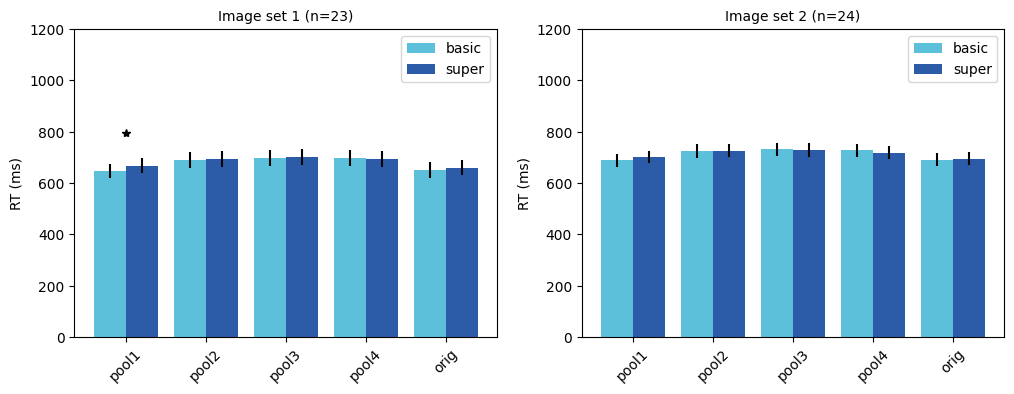

In [17]:
plot_utils.set_all_font_sizes(10)
plt.figure(figsize=(12,4))
    
for cbi, cb in enumerate([1,2]):

    ax = plt.subplot(1,2,cb)
    
    vals = rt_by_condition[subject_cb==cbi,:,:]
    
    n_subs_plot = vals.shape[0]
        
    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)
    
    lh = []
    
    for ii in range(n_image_types):
        
        for cc, cue in enumerate(cue_level_names):
        
            h = plt.bar(ii+xjitters[cc], \
                             meanvals[cc,ii], \
                            color = cue_level_colors[cc,:], width=barwidth)
            
            plt.errorbar(ii+xjitters[cc], \
                             meanvals[cc,ii], \
                             semvals[cc,ii], \
                            color = 'k',
                            linestyle='none')
        
            lh.append(h)
    
        if pvals[cbi, ii]<0.01:
            height = np.max(meanvals[:,ii]+semvals[:,ii])+100
            plt.plot(ii, height, '*', color='k')
    
        
    plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)
    
        
        
    
    # plt.axhline(0.0, color=[0.8, 0.8, 0.8], linestyle='--')
    
    ax.legend(lh, cue_level_names, loc='upper right')
    
    plt.ylabel('RT (ms)')
    
    plt.ylim([0, 1200])
    
    plt.title('Image set %d (n=%d)'%(cb, n_subs_plot))

#### pairwise comparisons across image types

In [18]:

for cbi, cb in enumerate([1,2]):
        
    pairs_test = list(itertools.combinations(np.arange(5),2))
    n_pairs = len(pairs_test)
    pair_names = ['%s vs %s'%(image_type_names[ii], image_type_names[jj]) for ii, jj in pairs_test]
    
    tvals = np.zeros((n_pairs))
    pvals = np.zeros((n_pairs))
    
    df = pd.DataFrame(index=pair_names)
    
    
    # averaging across basic/super conds here
    vals = np.mean(rt_by_condition[subject_cb==cbi,:,:], axis=1)

    print(vals.shape)
    for pi, pair in enumerate(pairs_test):
    
        vals1 = vals[:,pair[0]]
        vals2 = vals[:,pair[1]]
    
        p, t = stats_utils.paired_ttest_nonpar(vals1, vals2)
    
        tvals[pi] = t
        pvals[pi] = p
    
    df['t'] = tvals.round(4)
    
    _, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')
    df['p'] = pvals_fdr
    
    print('image set %d'%cb)
    print(df)   

(23, 5)
image set 1
                     t         p
pool1 vs pool2 -4.4717  0.005000
pool1 vs pool3 -4.6993  0.000000
pool1 vs pool4 -3.6009  0.008000
pool1 vs orig   0.1075  0.912000
pool2 vs pool3 -2.0614  0.082857
pool2 vs pool4 -0.8775  0.424444
pool2 vs orig   3.0361  0.010000
pool3 vs pool4  0.8519  0.424444
pool3 vs orig   3.8008  0.005000
pool4 vs orig   4.0959  0.005000
(24, 5)
image set 2
                     t         p
pool1 vs pool2 -5.6738  0.000000
pool1 vs pool3 -4.4051  0.000000
pool1 vs pool4 -3.0512  0.004000
pool1 vs orig   0.0842  0.902000
pool2 vs pool3 -1.0279  0.385000
pool2 vs pool4  0.5243  0.682222
pool2 vs orig   3.0283  0.013333
pool3 vs pool4  1.9473  0.108571
pool3 vs orig   4.2231  0.000000
pool4 vs orig   4.6755  0.000000
